# Analyzing this year's Auction Fantasy Football Drafts
#### Matthew Johnson

In [427]:
# Import necessary packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Dictionary to map leagues to draft dates
draft_date_dict = {'SNF': 'Aug 4', 'Westeros': 'Aug 7', 'RPPR': 'Aug 19', 'FIFL': 'Aug 22', 'YOLO': 'Aug 26'}

# Team name lists
my_teams = ['shadys ladies party', "Le'Theon Belljoy", 'forgot about trey', 'D.W.', 'Beanie Baby Hotel']
luke_teams = ["Luke's Team", "Luke's Team", "Luke's Team", "Luke's Team", "Slotty Receivers"]
ben_teams = ['-', '-', 'Mean Girls', "Ben's Legendary Team", "Ben's Team"]

# Placeholder lists to hold dataframes
my_list = []
luke_list = []
ben_list = []
draft_list = []

# Path suffix, example filename: SNFdraft.csv
path_suffix = 'draft.csv'


for i, draft in enumerate(draft_date_dict.keys()):
    draft_list.append( pd.read_csv(draft+ path_suffix) )
    draft_list[i].index = draft_list[i].Player
    draft_list[i].Cost = draft_list[i].Cost.str.lstrip('$')
    draft_list[i].Cost =  draft_list[i].Cost.astype('int64')  
    draft_list[i]['Position'] = draft_list[i].Player.str[-3:].str.rstrip(')').str.strip()
    draft_list[i].drop(['Player', 'Pick'], axis=1, inplace=True)
    
    # My drafted teams
    my_draft = draft_list[i][ draft_list[i]['Team'] == my_teams[i]]
    my_draft.drop(['Team'], axis=1, inplace=True)
    my_draft.columns = [draft, 'Position']
    my_list.append(my_draft)

    # Luke's drafted teams
    luke_draft = draft_list[i][ draft_list[i]['Team'] == luke_teams[i]]
    luke_draft.drop(['Team'], axis=1, inplace=True)
    luke_draft.columns = [draft, 'Position']
    luke_list.append(luke_draft)
    
    # Ben's drafted teams
    if i>1:
        ben_draft = draft_list[i][ draft_list[i]['Team'] == ben_teams[i]]
        ben_draft.drop(['Team'], axis=1, inplace=True)
        ben_draft.columns = [draft, 'Position']
        ben_list.append(ben_draft)
    
# Putting together all drafted list into dataframe
all_drafts = pd.concat(draft_list, axis=1)

# Make dataframe of player cost, adding mean and std of prices paid over all leagues
cost_df['mean'] = cost_df.mean(axis=1)
cost_df['std'] = np.round(cost_df.std(axis=1), 3)
#cost_df = all_drafts['Cost']
#cost_df.columns = draft_date_dict.keys()   # League Abbrevs as Columns
# cost_df.columns = draft_date_dict.values()  # Dates as Columns

# Putting together personal drafted lists into dataframes
my_df = pd.concat(my_list)
luke_df = pd.concat(luke_list)
ben_df = pd.concat(ben_list)


# Setting up Player : Position dictionary
position_df = all_drafts.Position.mode(axis=1)
position_df['Player'] = position_df.index
pos_dict = position_df.to_dict()[0]

In [445]:
def make_piv(df):
    df['personal_mean'] = df.mean(axis=1)
    df['count'] = df.drop(['Position','personal_mean'], axis=1).count(axis=1)
    draft_table = pd.pivot_table( index=df.index, values=df.columns, aggfunc=sum, data=df.fillna(0))
    draft_table = pd.concat([draft_table, cost_df[['mean', 'std']]], axis=1).fillna(0)
    draft_table['Position'] = pd.Series(draft_table.index).map(pos_dict).values
    draft_table['Position'] = draft_table['Position'].replace('EF', 'DEF')
    draft_table['Drafted'] = np.where(draft_table['count']>0, 1, 0)
    return draft_table

def group_by_league(df, start):
    by_league = []

    for i, league in enumerate(draft_date_dict.keys()):
        by_league.append(df[ df[league]>0])
        try:
            by_league[i]['League'] = league
            by_league[i]['Cost'] = by_league[i][league]
        except:
            print()
    leagues_df = pd.concat(by_league)

    league_piv = pd.pivot_table(index=['League', 'Position'], values = 'Cost', aggfunc=sum, data=leagues_df)
    league_piv.fillna(0, inplace=True)
    
    league_piv['index'] = league_piv.index
    league_piv['League'] = league_piv['index'].apply(lambda x: x[0])
    league_piv['Position'] = league_piv['index'].apply(lambda x: x[1])
    
    return league_piv.drop('index', axis=1)


my_drafts = make_piv(my_df)
luke_drafts = make_piv(luke_df)
ben_drafts = make_piv(ben_df)

ben_drafts['SNF']=0
ben_drafts['Westeros']=0

mydf = my_drafts[ my_drafts['count']>0]
lukedf = luke_drafts[ luke_drafts['count']>0]
bendf = ben_drafts[ ben_drafts['count']>0]
print('my unique players:', len(mydf), "\tluke's unique players:", len(lukedf), "\tben's unique players:", len(bendf))


my_league_piv = group_by_league(my_drafts, 0)
luke_league_piv = group_by_league(luke_drafts, 0)
ben_league_piv = group_by_league(ben_drafts, 2)

my unique players: 58 	luke's unique players: 61 	ben's unique players: 37


In [446]:
all_df = make_piv(all_drafts).drop(['count','Drafted'], axis=1)
all_df.columns = list(draft_date_dict.keys()) +  ['personal_mean', 'mean', 'std', 'Position']
all_df.head()

,SNF,Westeros,RPPR,FIFL,YOLO,personal_mean,mean,std,Position
A.J. Green (Cin - WR),34.0,38.0,41.0,37.0,41.0,38.2,38.2,2.638,WR
Aaron Jones (GB - RB),1.0,4.0,9.0,7.0,5.0,5.2,5.2,2.713,RB
Aaron Rodgers (GB - QB),16.0,24.0,16.0,16.0,25.0,19.4,19.4,4.176,QB
Adam Thielen (Min - WR),20.0,27.0,27.0,30.0,28.0,26.4,26.4,3.382,WR
Adrian Peterson (Was - RB),0.0,0.0,0.0,3.0,6.0,4.5,4.5,1.500,RB


In [447]:
my_drafts.to_csv('mydrafts_aug27.csv')
luke_drafts.to_csv('lukedrafts_aug27.csv')
my_league_piv.to_csv('mydrafts_3.csv')
luke_league_piv.to_csv('lukedrafts_3.csv')
ben_league_piv.to_csv('ben3.csv')

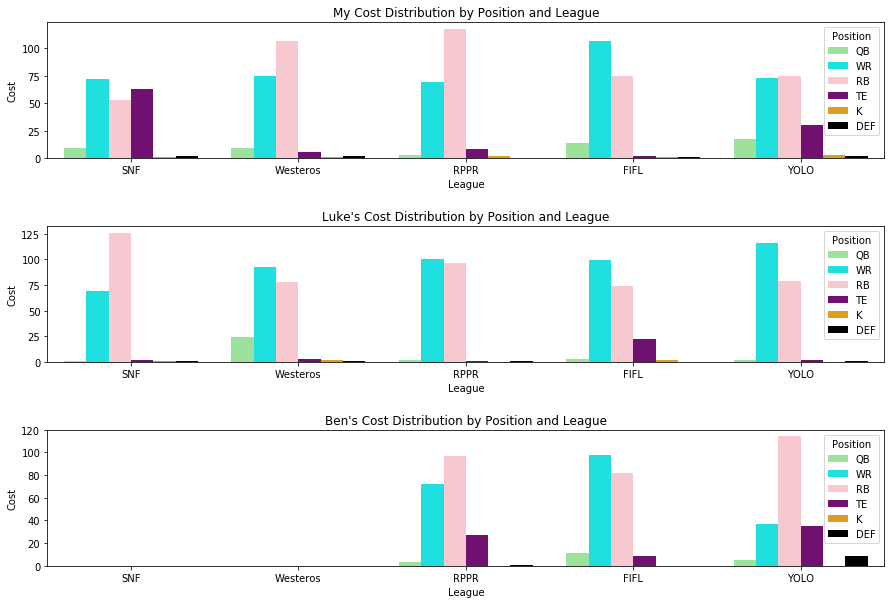

In [449]:
pal = {'DEF':'black', 'K':'orange', 'QB':'lightgreen', 'RB':'pink', 'TE':'purple', 'WR': 'cyan'}
pos_order = ['QB', 'WR', 'RB', 'TE', 'K', 'DEF']

plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
sns.barplot(x='League', y='Cost', hue='Position', data=my_league_piv, palette=pal, 
            order = draft_date_dict.keys(), hue_order=pos_order);
plt.title('My Cost Distribution by Position and League');

plt.subplot(3,1,2)
sns.barplot(x='League', y='Cost', hue='Position', data=luke_league_piv, palette=pal, 
            order = draft_date_dict.keys(), hue_order=pos_order)
plt.title("Luke's Cost Distribution by Position and League");

plt.subplot(3,1,3)
sns.barplot(x='League', y='Cost', hue='Position', data=ben_league_piv, palette=pal, 
            order = draft_date_dict.keys(), hue_order=pos_order)
plt.title("Ben's Cost Distribution by Position and League");

plt.subplots_adjust(hspace=0.5);

In [458]:
# TODO: bin player prices 1-10, 11-20, ... , 70+
# SAME PLOT AS ABOVE BUT INSTEAD OF POSITION (HUE) -> BINNED PRICES
# NO POSITION ASPECT OF PLOT

my_league_piv['binned_cost'] = my_league_piv['Cost']//10

In [470]:
for league in draft_date_dict.keys():
    mydf[league +'_binned'] = mydf[league]//10
    

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
sns.barplot(x='League', y='Cost', hue='Position', data=my_league_piv, palette=pal, 
            order = draft_date_dict.keys(), hue_order=pos_order);
plt.title('My Cost Distribution by Position and League');

plt.subplot(3,1,2)
sns.barplot(x='League', y='Cost', hue='Position', data=luke_league_piv, palette=pal, 
            order = draft_date_dict.keys(), hue_order=pos_order)
plt.title("Luke's Cost Distribution by Position and League");

plt.subplot(3,1,3)
sns.barplot(x='League', y='Cost', hue='Position', data=ben_league_piv, palette=pal, 
            order = draft_date_dict.keys(), hue_order=pos_order)
plt.title("Ben's Cost Distribution by Position and League");

plt.subplots_adjust(hspace=0.5);

**My most drafted players:**

In [246]:
my_drafts.sort_values(by='count', ascending=False)[0:10]

,FIFL,RPPR,SNF,Westeros,YOLO,count,personal_mean,mean,std,Position,Drafted
Amari Cooper (Oak - WR),25.0,25.0,0.0,0.0,29.0,3.0,79.0,21.60,6.375,WR,1
Josh Doctson (Was - WR),1.0,1.0,1.0,0.0,0.0,3.0,3.0,1.20,0.400,WR,1
Latavius Murray (Min - RB),3.0,0.0,0.0,1.0,3.0,3.0,7.0,1.80,0.980,RB,1
Patrick Mahomes II (KC - QB),0.0,2.0,0.0,1.0,0.0,2.0,3.0,1.40,0.490,QB,1
Cam Newton (Car - QB),0.0,0.0,9.0,8.0,0.0,2.0,17.0,9.60,1.625,QB,1
Devonta Freeman (Atl - RB),0.0,0.0,33.0,0.0,36.0,2.0,69.0,37.00,2.449,RB,1
Austin Ekeler (LAC - RB),1.0,1.0,0.0,0.0,0.0,2.0,2.0,1.00,0.000,RB,1
Dede Westbrook (Jax - WR),1.0,0.0,0.0,0.0,2.0,2.0,3.0,1.25,0.433,WR,1
Travis Kelce (KC - TE),0.0,0.0,26.0,0.0,30.0,2.0,56.0,27.20,3.187,TE,1
Jake Elliott (Phi - K),1.0,1.0,0.0,0.0,0.0,2.0,2.0,2.80,3.600,K,1


In [456]:
34//10

3

In [407]:
def get_all_pos_df(posdf):
    posdf.fillna(0, inplace=True)
    posdf['mean'] = posdf.mean(axis=1)
    posdf['diff'] = posdf['YOLO'] - posdf['SNF']
    posdf['abs_diff'] = abs(posdf['diff'])
    posdf['diff_pct'] = np.round((100*posdf['diff'])/posdf['SNF'], 2)
    for col in ['mean', 'diff_pct']:
        posdf[col] = np.round(posdf[col], 2)
    return posdf.drop('personal_mean', axis=1)

In [413]:
all_players = all_df.copy()
all_players = get_all_pos_df(all_players)
#copy_df.to_csv('all_drafts_data_aug27.csv')
all_players.sort_values(by='abs_diff', ascending=False)[0:10]

,SNF,Westeros,RPPR,FIFL,YOLO,mean,std,Position,diff,abs_diff,diff_pct
Derrius Guice (Was - RB),20.0,23.0,0.0,0.0,0.0,10.25,1.500,RB,-20.0,20.0,-100.00
Amari Cooper (Oak - WR),11.0,18.0,25.0,25.0,29.0,19.48,6.375,WR,18.0,18.0,163.64
Chris Hogan (NE - WR),6.0,13.0,20.0,21.0,23.0,15.19,6.280,WR,17.0,17.0,283.33
Todd Gurley II (LAR - RB),82.0,68.0,68.0,66.0,68.0,61.09,5.851,RB,-14.0,14.0,-17.07
Odell Beckham Jr. (NYG - WR),41.0,50.0,56.0,54.0,54.0,44.46,5.367,WR,13.0,13.0,31.71
Paul Richardson Jr. (Was - WR),1.0,0.0,0.0,0.0,14.0,4.46,6.500,WR,13.0,13.0,1300.00
Doug Baldwin (Sea - WR),25.0,29.0,29.0,33.0,38.0,27.09,4.400,WR,13.0,13.0,52.00
Christian McCaffrey (Car - RB),32.0,37.0,41.0,44.0,45.0,34.82,4.792,RB,13.0,13.0,40.62
Chris Carson (Sea - RB),1.0,3.0,10.0,6.0,14.0,6.63,4.707,RB,13.0,13.0,1300.00
Kenyan Drake (Mia - RB),13.0,24.0,21.0,24.0,24.0,18.87,4.261,RB,11.0,11.0,84.62


In [415]:
WRs = all_players[ all_players['Position']=='WR'].drop('Position', axis=1)
WRs.sort_values(by='abs_diff', ascending=False)[0:10]

,SNF,Westeros,RPPR,FIFL,YOLO,mean,std,diff,abs_diff,diff_pct
Amari Cooper (Oak - WR),11.0,18.0,25.0,25.0,29.0,19.48,6.375,18.0,18.0,163.64
Chris Hogan (NE - WR),6.0,13.0,20.0,21.0,23.0,15.19,6.280,17.0,17.0,283.33
Odell Beckham Jr. (NYG - WR),41.0,50.0,56.0,54.0,54.0,44.46,5.367,13.0,13.0,31.71
Paul Richardson Jr. (Was - WR),1.0,0.0,0.0,0.0,14.0,4.46,6.500,13.0,13.0,1300.00
Doug Baldwin (Sea - WR),25.0,29.0,29.0,33.0,38.0,27.09,4.400,13.0,13.0,52.00
Davante Adams (GB - WR),35.0,42.0,40.0,52.0,45.0,37.49,5.636,10.0,10.0,28.57
Tyreek Hill (KC - WR),18.0,29.0,28.0,28.0,28.0,23.12,4.118,10.0,10.0,55.56
Keenan Allen (LAC - WR),35.0,47.0,45.0,48.0,44.0,38.22,4.622,9.0,9.0,25.71
Julio Jones (Atl - WR),42.0,51.0,51.0,48.0,51.0,42.18,3.499,9.0,9.0,21.43
Brandin Cooks (LAR - WR),11.0,21.0,12.0,14.0,20.0,14.07,4.128,9.0,9.0,81.82


In [416]:
RBs = all_players[ all_players['Position']=='RB'].drop('Position', axis=1)
RBs.sort_values(by='abs_diff', ascending=False)[0:10]

,SNF,Westeros,RPPR,FIFL,YOLO,mean,std,diff,abs_diff,diff_pct
Derrius Guice (Was - RB),20.0,23.0,0.0,0.0,0.0,10.25,1.500,-20.0,20.0,-100.00
Todd Gurley II (LAR - RB),82.0,68.0,68.0,66.0,68.0,61.09,5.851,-14.0,14.0,-17.07
Chris Carson (Sea - RB),1.0,3.0,10.0,6.0,14.0,6.63,4.707,13.0,13.0,1300.00
Christian McCaffrey (Car - RB),32.0,37.0,41.0,44.0,45.0,34.82,4.792,13.0,13.0,40.62
Kenyan Drake (Mia - RB),13.0,24.0,21.0,24.0,24.0,18.87,4.261,11.0,11.0,84.62
Marshawn Lynch (Oak - RB),2.0,7.0,9.0,14.0,13.0,8.46,4.336,11.0,11.0,550.00
Lamar Miller (Hou - RB),9.0,15.0,21.0,22.0,19.0,15.51,4.750,10.0,10.0,111.11
Kareem Hunt (KC - RB),41.0,43.0,46.0,43.0,50.0,38.72,3.137,9.0,9.0,21.95
Chris Thompson (Was - RB),2.0,6.0,8.0,9.0,10.0,6.56,2.828,8.0,8.0,400.00
Royce Freeman (Den - RB),9.0,8.0,19.0,22.0,17.0,13.74,5.550,8.0,8.0,88.89


In [417]:
TEs = all_players[ all_players['Position']=='TE'].drop('Position', axis=1)
TEs.sort_values(by='abs_diff', ascending=False)[0:10]

,SNF,Westeros,RPPR,FIFL,YOLO,mean,std,diff,abs_diff,diff_pct
David Njoku (Cle - TE),1.0,1.0,3.0,4.0,10.0,3.89,3.311,9.0,9.0,900.000000
Greg Olsen (Car - TE),5.0,13.0,8.0,9.0,13.0,8.81,3.072,8.0,8.0,160.000000
Travis Kelce (KC - TE),26.0,31.0,27.0,22.0,30.0,23.86,3.187,4.0,4.0,15.380000
Zach Ertz (Phi - TE),20.0,20.0,25.0,25.0,23.0,19.81,2.245,3.0,3.0,15.000000
Trey Burton (Chi - TE),3.0,4.0,8.0,10.0,6.0,5.85,2.561,3.0,3.0,100.000000
Rob Gronkowski (NE - TE),37.0,35.0,37.0,37.0,35.0,31.27,0.980,-2.0,2.0,-5.410000
Jordan Reed (Was - TE),4.0,4.0,2.0,4.0,2.0,3.08,0.980,-2.0,2.0,-50.000000
Tyler Eifert (Cin - TE),1.0,2.0,1.0,0.0,0.0,1.07,0.471,-1.0,1.0,-100.000000
Eric Ebron (Ind - TE),0.0,0.0,1.0,1.0,1.0,0.81,0.000,1.0,1.0,inf
Evan Engram (NYG - TE),8.0,11.0,11.0,15.0,7.0,9.46,2.800,-1.0,1.0,-12.500000


In [419]:
DEFs = all_players[ all_players['Position']=='DEF'].drop('Position', axis=1)
DEFs.sort_values(by='abs_diff', ascending=False)[0:10]

,SNF,Westeros,RPPR,FIFL,YOLO,mean,std,diff,abs_diff,diff_pct
Los Angeles (LAR - DEF),2.0,2.0,3.0,1.0,9.0,3.49,2.871,7.0,7.0,350.000000
Philadelphia (Phi - DEF),2.0,3.0,1.0,2.0,6.0,2.84,1.720,4.0,4.0,200.000000
Jacksonville (Jax - DEF),3.0,6.0,4.0,4.0,6.0,4.31,1.200,3.0,3.0,100.000000
Denver (Den - DEF),1.0,4.0,1.0,1.0,3.0,2.10,1.265,2.0,2.0,200.000000
Seattle (Sea - DEF),1.0,1.0,0.0,0.0,0.0,0.67,0.000,-1.0,1.0,-100.000000
Baltimore (Bal - DEF),2.0,2.0,1.0,1.0,1.0,1.49,0.490,-1.0,1.0,-50.000000
Buffalo (Buf - DEF),0.0,0.0,0.0,0.0,1.0,0.50,0.000,1.0,1.0,inf
Houston (Hou - DEF),2.0,2.0,1.0,1.0,1.0,1.49,0.490,-1.0,1.0,-50.000000
Atlanta (Atl - DEF),0.0,0.0,0.0,0.0,1.0,0.50,0.000,1.0,1.0,inf
New England (NE - DEF),0.0,1.0,0.0,1.0,0.0,0.67,0.000,0.0,0.0,NaN


In [133]:
cost_df.sort_values(by='mean', ascending=False)[0:10]

,SNF,Westeros,RPPR,FIFL,YOLO,mean,std
Todd Gurley II (LAR - RB),82.0,68.0,68.0,66.0,68.0,70.4,5.851
David Johnson (Ari - RB),69.0,64.0,68.0,64.0,66.0,66.2,2.040
Le'Veon Bell (Pit - RB),69.0,67.0,65.0,64.0,64.0,65.8,1.939
Ezekiel Elliott (Dal - RB),68.0,60.0,61.0,61.0,63.0,62.6,2.871
Antonio Brown (Pit - WR),63.0,61.0,60.0,59.0,60.0,60.6,1.356
Alvin Kamara (NO - RB),58.0,66.0,59.0,57.0,54.0,58.8,3.970
Melvin Gordon (LAC - RB),51.0,57.0,56.0,54.0,54.0,54.4,2.059
DeAndre Hopkins (Hou - WR),51.0,59.0,55.0,50.0,52.0,53.4,3.262
Saquon Barkley (NYG - RB),49.0,46.0,57.0,49.0,56.0,51.4,4.317
Odell Beckham Jr. (NYG - WR),41.0,50.0,56.0,54.0,54.0,51.0,5.367


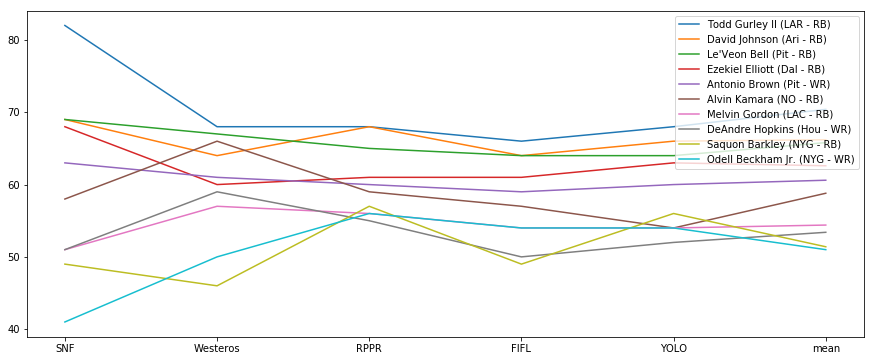

In [410]:
x = cost_df.drop(['std'],axis=1).sort_values(by='mean', ascending=False)[0:10]
plt.figure(figsize=(15,6))

plt.plot(x.T)
plt.legend(x.index);